# note: do evaluation in (N,C,L) format, this way the accuracy is better reflected, and we still get stel predictions over time

In [7]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from dataloaders.grid_loader import GridDataLoaders
from datasets.grid_dataset import GridDataGroup
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score

In [8]:
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold
from models.model_result import ModelResult
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, TriangularMovingAverage, HistoricAverage

In [9]:
conf_dict = {
    "seed": 3,
    "resume": False,
    "early_stopping": False,
    "use_cuda": False,
    "val_ratio": 0.1,
    "tst_ratio": 0.2,
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    "flatten_grid": True,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 10,
    "batch_size": 64,
    "dropout": 0,
    "shuffle": False,
    "num_workers": 6,
    "seq_len": 1
}

conf = BaseConf(conf_dict)

data_dim_str = "T24H-X850M-Y880M"  # needs to exist
data_path = f"./data/processed/{data_dim_str}/"
os.makedirs(data_path, exist_ok=True)

In [6]:
data_group = GridDataGroup(data_path=data_path, conf=conf)

#### Mean of training data as future prediction

In [25]:
# Mean of training data as future prediction

trn_crimes = data_group.training_set.crimes

crimes_mean = np.mean(trn_crimes[:,0],axis=0,keepdims=True)
crimes_ones = np.ones_like(data_group.testing_set.targets)
y_pred_sparse = crimes_mean*crimes_ones
targets_dense = data_group.shaper.squeeze(data_group.testing_set.targets)
y_pred_dense = data_group.shaper.squeeze(y_pred_sparse)

probas_pred = y_pred_dense.flatten()
y_true = targets_dense.flatten()
thresh = best_threshold(y_true, probas_pred)
y_pred = np.copy(probas_pred)
y_pred[y_pred >= thresh] = 1
y_pred[y_pred < thresh] = 0

mean_model_result = ModelResult(model_name="Train Mean",
                     y_true=y_true,
                     y_pred=y_pred,
                     probas_pred=probas_pred,
                    t_range=data_group.training_set.t_range)

f1_score: 0.6969299887682516 at index 288, new threshold -0.8047743504343398


#### Rolling mean of all data 

In [18]:
model_results = []

for window_len in [14]:
    uma = TriangularMovingAverage(window_len=window_len)
    all_crimes = data_group.crimes[:,0]
    tst_targets = data_group.testing_set.targets
    all_crimes_ma = uma(all_crimes)
    tst_crimes_ma = all_crimes_ma[-len(tst_targets):]

    targets_dense = data_group.shaper.squeeze(tst_targets)
    y_pred_dense = data_group.shaper.squeeze(tst_crimes_ma)

    probas_pred = y_pred_dense.flatten()
    y_true = targets_dense.flatten()

    print(f"{y_true.shape}, {probas_pred.shape}")

    thresh = best_threshold(y_true, probas_pred)
    y_pred = np.copy(probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0

    uma_model_result = ModelResult(model_name=f"UMA {window_len}",
                         y_true=y_true,
                         y_pred=y_pred,
                         probas_pred=probas_pred,
                        t_range=data_group.training_set.t_range)
    model_results.append(uma_model_result)

(54936,), (54936,)
f1_score: 0.6827562616396184 at index 1059, new threshold -0.8222106865044907



            Model Name: UMA 14
                ROC AUC:            0.7909809272676682
                Average Precision:  0.7171635507625228
                Accuracy:           0.6961191204310471
        

            Model Name: Train Mean
                ROC AUC:            0.8091654668857733
                Average Precision:  0.7363652990240656
                Accuracy:           0.7052934323576525
        


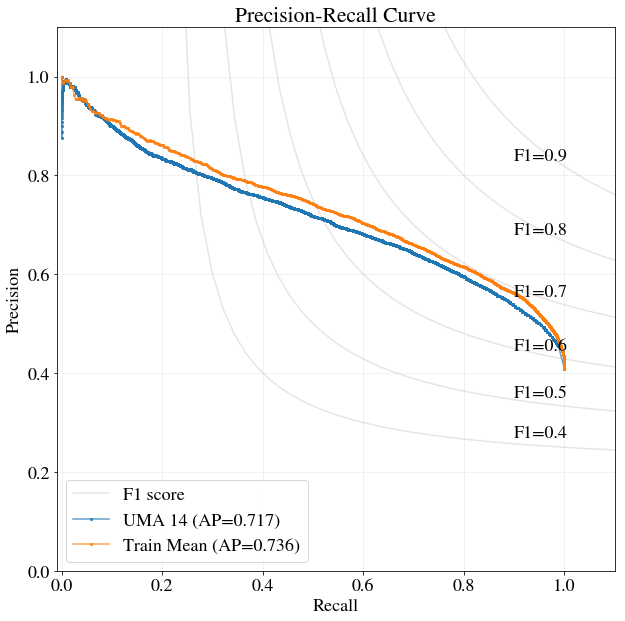

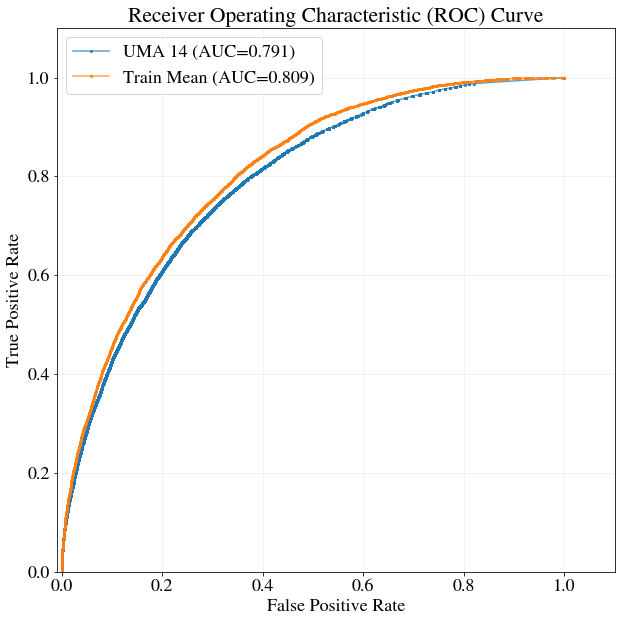

In [19]:
model_results.append(mean_model_result)
for result in model_results:
    print(result)


pr_plotter = PRCurvePlotter()
for result in model_results:
    pr_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
pr_plotter.show()
# pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
for result in model_results:
    roc_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
roc_plotter.show()
# roc_plotter.savefig(model_path + "plot_roc_curve.png")

In [20]:
drop_out_mask = np.random.binomial(1,0.5,10)

### Plot cells per time